In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import os
os.chdir("/Users/zyxu/Documents/R/23spring")

import jax.numpy as jnp

# Load the matrix from the CSV file
matrix_data = pd.read_csv("CRC_matrix_data.csv")

matrix_data.shape

study_names = pd.read_csv("CRC_study_name.csv")
study_names['study'] = study_names['x']
study_names

,x,study
0,FengQ_2015,FengQ_2015
1,FengQ_2015,FengQ_2015
2,FengQ_2015,FengQ_2015
3,FengQ_2015,FengQ_2015
4,FengQ_2015,FengQ_2015
...,...,...
1390,ZellerG_2014,ZellerG_2014
1391,ZellerG_2014,ZellerG_2014
1392,ZellerG_2014,ZellerG_2014
1393,ZellerG_2014,ZellerG_2014


In [21]:
U, Sigma, Vt = np.linalg.svd(matrix_data.values, full_matrices=False)

In [24]:
Sigma

array([1.69165087e+07, 1.52424807e+07, 7.51466492e+06, 5.79478789e+06,
       4.62723142e+06, 4.21385187e+06, 3.82899004e+06, 3.52912177e+06,
       3.27423959e+06, 3.09098754e+06, 2.90643187e+06, 2.79128804e+06,
       2.77903277e+06, 2.63041430e+06, 2.48631475e+06, 2.43863023e+06,
       2.42318346e+06, 2.27037165e+06, 2.19367037e+06, 2.11100375e+06,
       1.96913206e+06, 1.89678436e+06, 1.81234291e+06, 1.71705335e+06,
       1.46530396e+06, 1.44533826e+06, 1.41902515e+06, 1.38208132e+06,
       1.36101659e+06, 1.31463111e+06, 1.29928932e+06, 1.26619924e+06,
       1.21069730e+06, 1.16617737e+06, 1.11922470e+06, 1.01900348e+06,
       1.00515273e+06, 9.74383177e+05, 9.59295151e+05, 9.09051593e+05,
       8.95937868e+05, 8.59703960e+05, 8.43578382e+05, 8.33789163e+05,
       8.22085348e+05, 8.09274053e+05, 7.86072201e+05, 7.63734307e+05,
       7.55633831e+05, 7.39862423e+05, 7.32559078e+05, 7.17091619e+05,
       7.02948828e+05, 6.87487199e+05, 6.79668869e+05, 6.72699181e+05,
      

<Axes: >

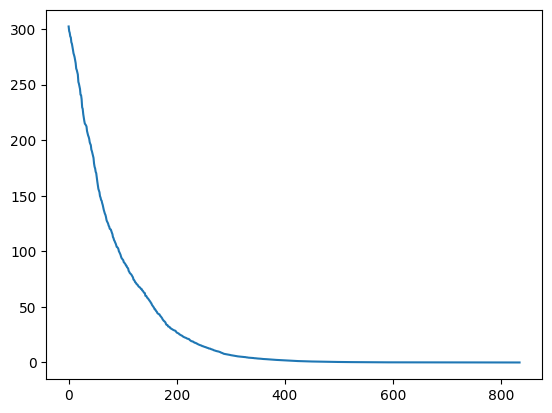

In [31]:
sns.lineplot(Sigma[100:1000]/1000)

In [9]:
threshold = 0.98 * matrix_data.shape[0]
cols_with_zeros = (matrix_data == 0).sum(axis=0) > threshold
selected_species = matrix_data.columns[cols_with_zeros]
threshold_study = 1

results = {}

for species in selected_species:
    species_data = matrix_data[species]
    
    zero_data = study_names.copy()
    zero_data['zeros'] = (species_data == 0)
    
    # Count total and zero samples for each study
    total_samples_per_study = zero_data.groupby('study').size()
    zero_samples_per_study = zero_data.groupby('study').sum(numeric_only=True)['zeros']
    
    # Find studies with a high proportion of zeros
    high_zero_studies = (zero_samples_per_study / total_samples_per_study) >= threshold_study
    # print((zero_samples_per_study / total_samples_per_study))
    
    results[species] = high_zero_studies[high_zero_studies].index.tolist()

unique_studies = study_names['study'].unique()


In [10]:
import torch
V = torch.load("output/best_V.pt")
V.shape

torch.Size([935, 10])

In [12]:
studies_data = [matrix_data[study_names['study'] == study].values for study in unique_studies]
# Create C matrices for each study based on species with a high proportion of zeros
def construct_C_for_study(study, results, matrix_data):
    C = jnp.eye(935)
    species_with_high_zeros = results.keys() & set(matrix_data.columns)
    for species in species_with_high_zeros:
        if study in results[species]:
            species_index = matrix_data.columns.get_loc(species)
            C = C.at[species_index, species_index].set(0)
    return C

# Constructing Cs for each study
Cs = [construct_C_for_study(study, results, matrix_data) for study in unique_studies]


In [15]:

study_decompositions = {}
for i, study in enumerate(unique_studies):
    X = studies_data[i]
    print(jnp.dot(X, Cs[i]).shape)
    U, Sigma, _ = jnp.linalg.svd(jnp.dot(X, Cs[i]) @ V.detach().numpy(), full_matrices=False)
    rank = 10
    U, Sigma = U[:, :rank], Sigma[:rank]
    study_decompositions[study] = (U, Sigma)

(107, 935)
(60, 935)
(55, 935)
(53, 935)
(60, 935)
(80, 935)
(104, 935)
(125, 935)
(509, 935)
(128, 935)
(114, 935)


In [16]:
study_decompositions.keys()

dict_keys(['FengQ_2015', 'GuptaA_2019', 'HanniganGD_2017', 'ThomasAM_2018a', 'ThomasAM_2018b', 'ThomasAM_2019_c', 'VogtmannE_2016', 'WirbelJ_2018', 'YachidaS_2019', 'YuJ_2015', 'ZellerG_2014'])

# traditinoal

In [17]:

import numpy as np
import pandas as pd

# Assuming matrix_data is a DataFrame and study_names is a column vector of the same length

unique_studies = study_names['x'].unique()
study_decompositions_traditional = {}

for study in unique_studies:
    # Step 1: Select rows for the current study
    X = matrix_data[study_names['x'] == study].values
    
    # Step 2: SVD decomposition
    U, Sigma, Vt = np.linalg.svd(X, full_matrices=False)
    
    # Step 3: Retain only top 1/10 singular values and vectors
    rank = 10
    U = U[:, :rank]
    Sigma = Sigma[:rank]
    Vt = Vt[:rank, :]
    
    # Step 4: Construct C matrix
    C = np.eye(935)
    species_with_high_zeros = results.keys() & set(matrix_data.columns)
    for species in species_with_high_zeros:
        if study in results[species]:
            species_index = matrix_data.columns.get_loc(species)
            C[species_index, species_index] = 0
    
    study_decompositions_traditional[study] = (U, Sigma, Vt, C)


<Axes: >

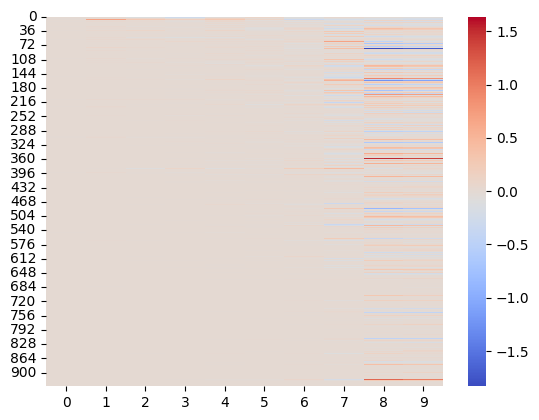

In [18]:
sns.heatmap(V.detach().numpy(),  cmap='coolwarm', cbar=True)

In [13]:
V.detach().numpy()

array([[-2.5321519e-02,  1.0091579e-01,  4.2666458e-02, ...,
        -6.8887778e-02,  6.2685676e-02,  3.6571607e-02],
       [-3.3897024e-03,  9.0464605e-03, -1.0870425e-03, ...,
        -2.6343552e-02,  5.5497326e-02,  4.6251446e-02],
       [ 1.2123706e-03,  9.5309168e-03, -9.8750129e-02, ...,
         3.3275612e-02, -2.9078173e-02, -6.7635670e-02],
       ...,
       [ 2.6200928e-07,  3.5654358e-04,  1.4245421e-07, ...,
         3.0326237e-05,  1.2213724e-03,  1.5365127e-03],
       [ 2.1635543e-08, -8.2800354e-05, -4.6889929e-07, ...,
        -3.6941001e-05,  2.7807895e-03,  2.3857234e-03],
       [ 4.2641096e-07,  3.2138185e-05,  9.7353973e-07, ...,
         1.6355516e-04, -1.8938341e-03,  1.3188506e-03]], dtype=float32)

In [ ]:
study_groundTruth =  {}
for key in unique_studies:
    study_groundTruth[key] = U = torch.randn((4,5))

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample study
study = unique_studies[0]

def plot_study_U(study):
    U_study = study_decompositions[study][0]
    U_study_traditional = study_decompositions_traditional[study][0]
    # U_difference = U_study - U_study_traditional
    U_groundTruth = study_groundTruth[study][0]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Heatmap of U from study_decompositions
    sns.heatmap(U_study, ax=axes[0], cmap='coolwarm', cbar=False)
    axes[0].set_title('U from study_decompositions')

    # Heatmap of U from study_decompositions_traditional
    sns.heatmap(U_study_traditional, ax=axes[1], cmap='coolwarm', cbar=False)
    axes[1].set_title('U from study_decompositions_traditional')

    # Ground truth U
    sns.heatmap(U_groundTruth, ax=axes[2], cmap='coolwarm')
    axes[2].set_title('Ground truth U matrices')

    # Heatmap of the difference
    # sns.heatmap(U_difference, ax=axes[2], cmap='coolwarm')
    # axes[2].set_title('Difference between U matrices')



    plt.tight_layout()
    plt.show()

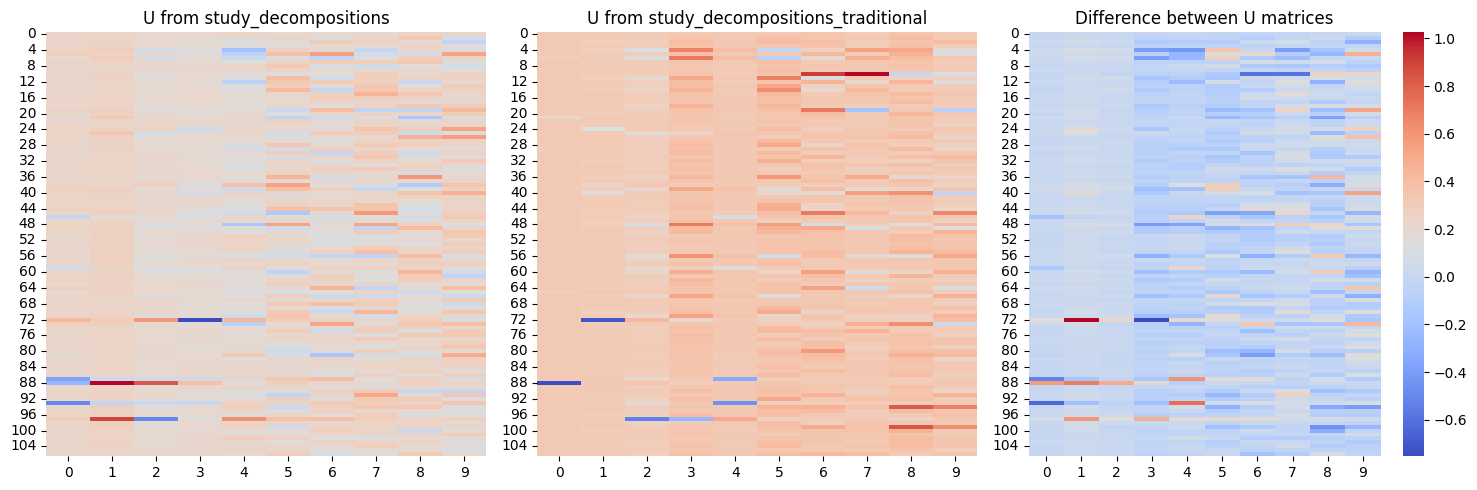

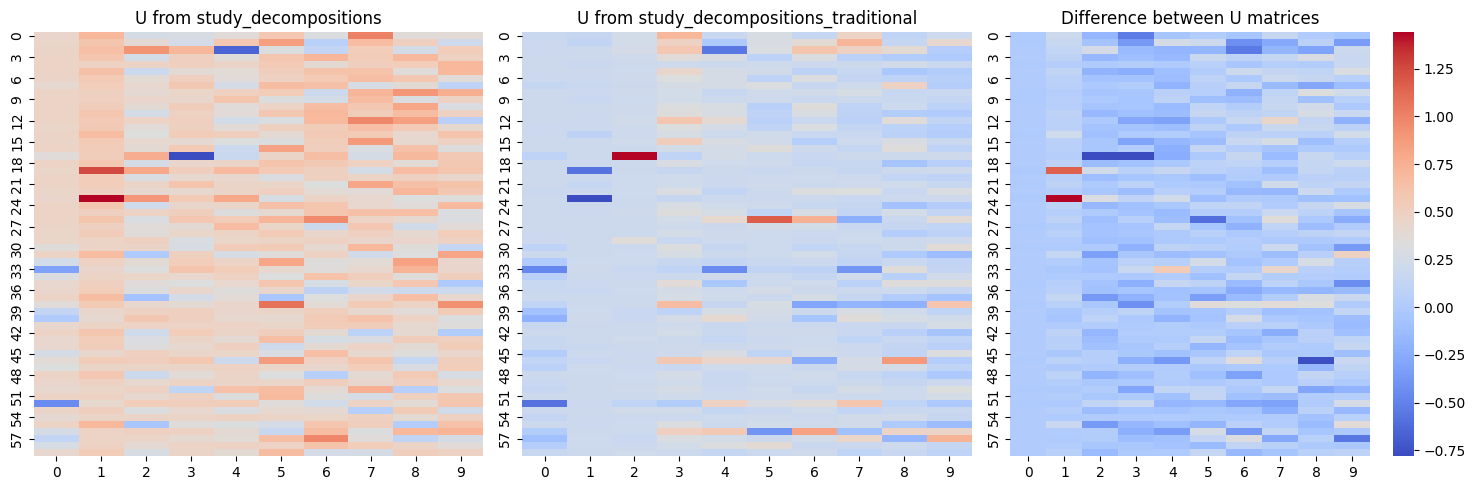

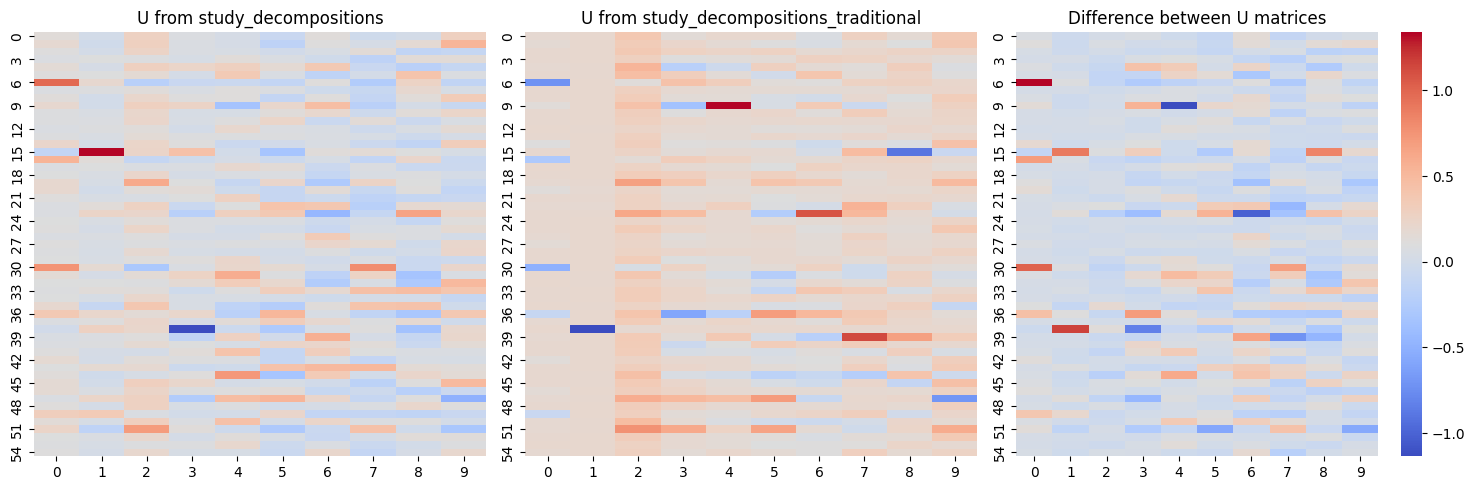

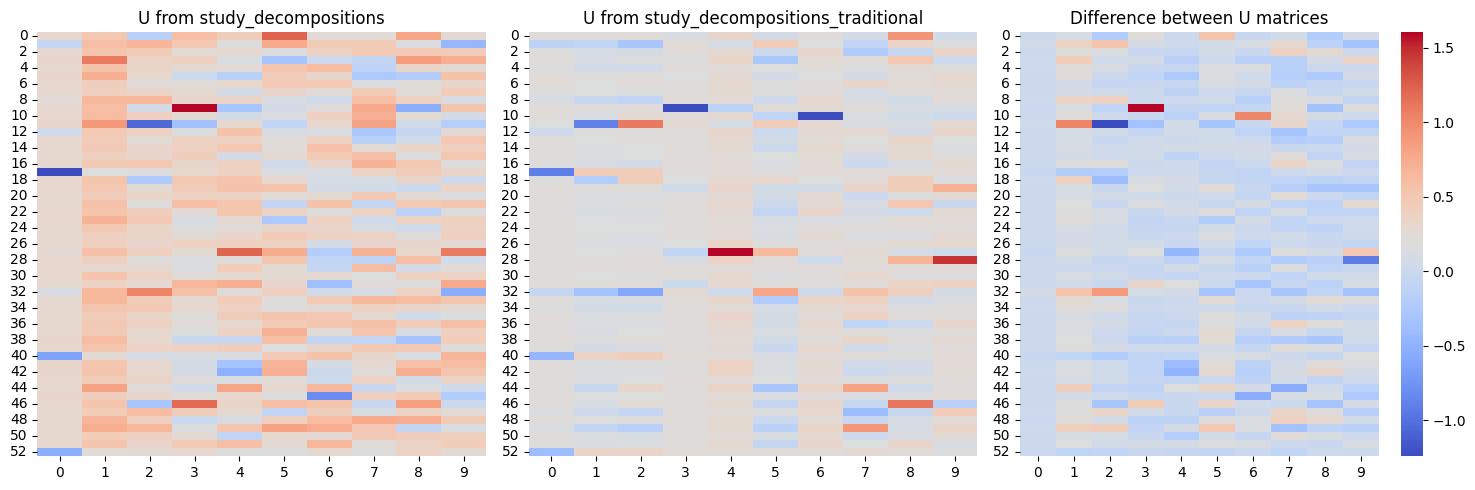

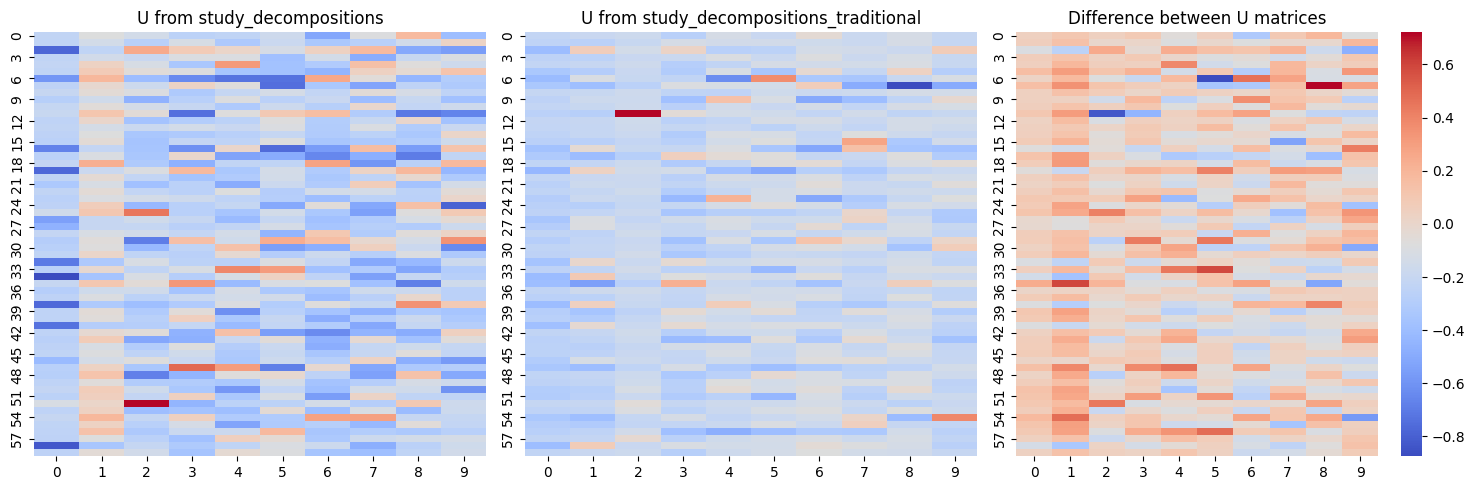

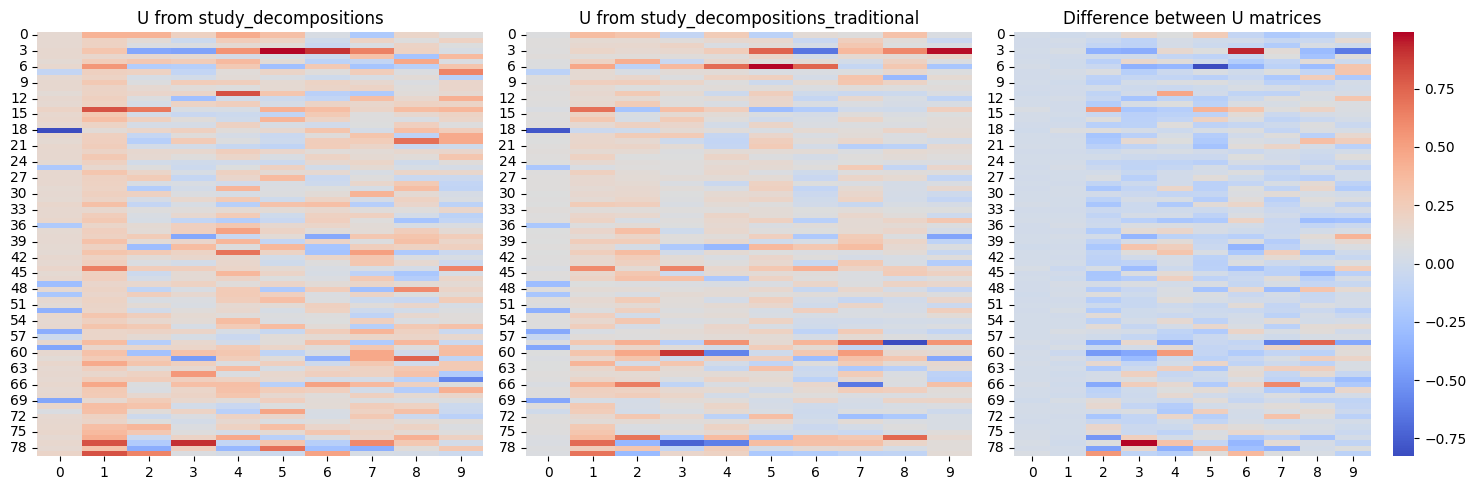

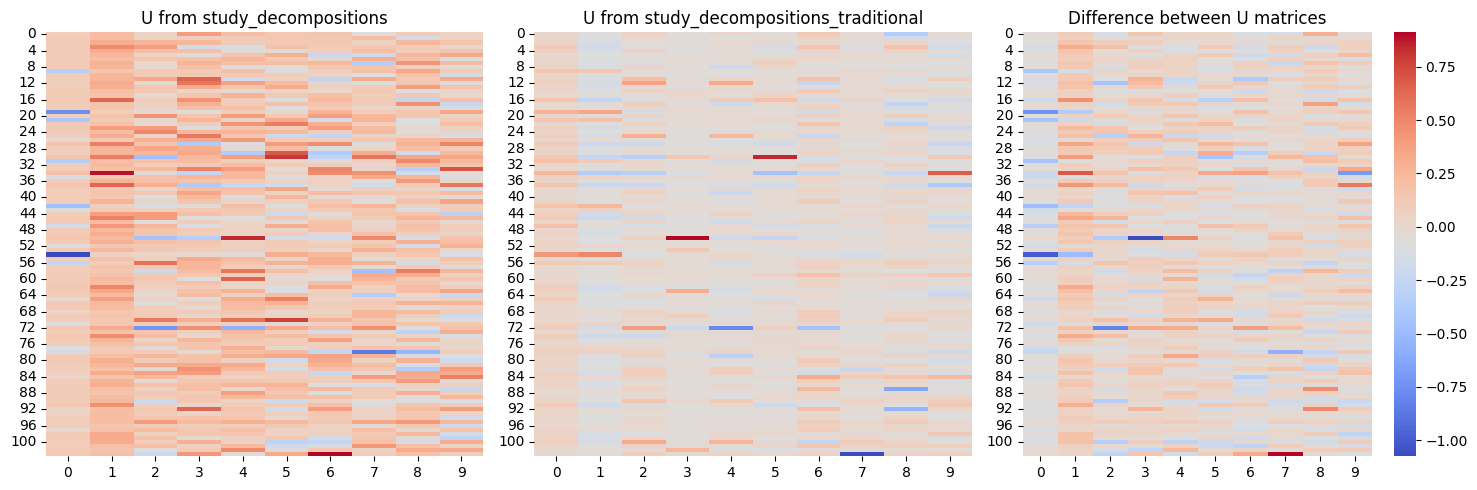

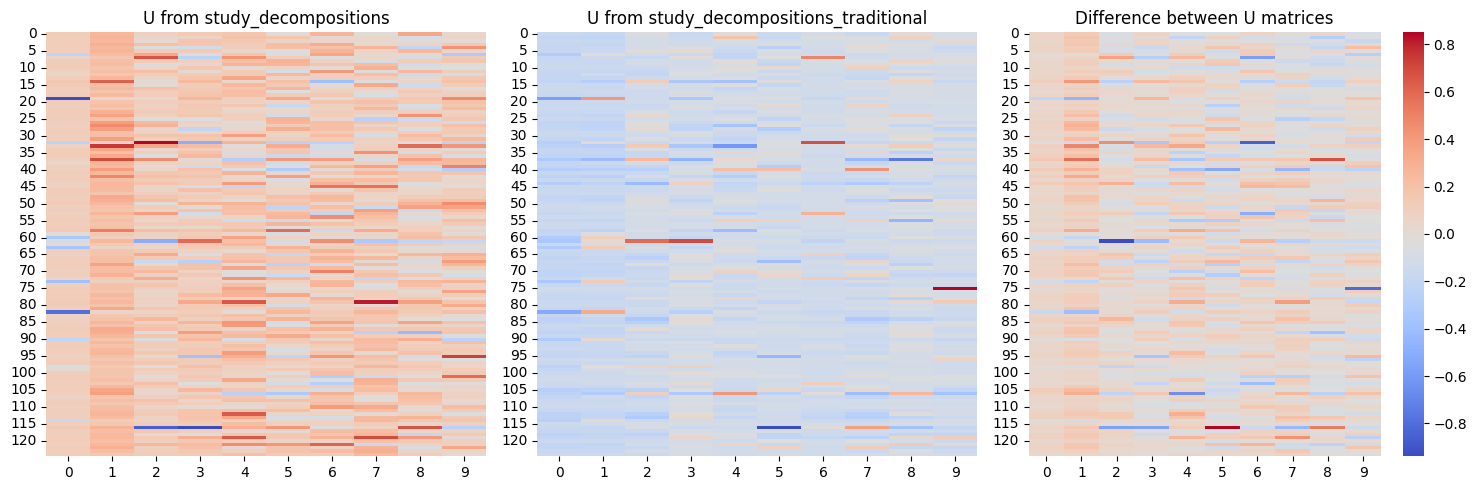

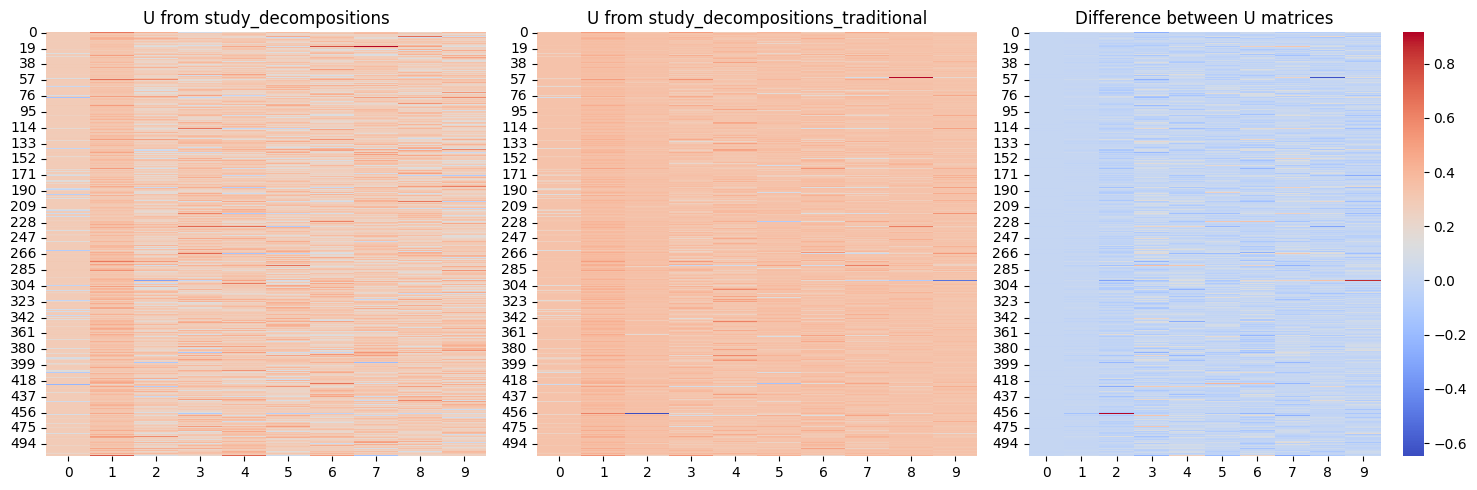

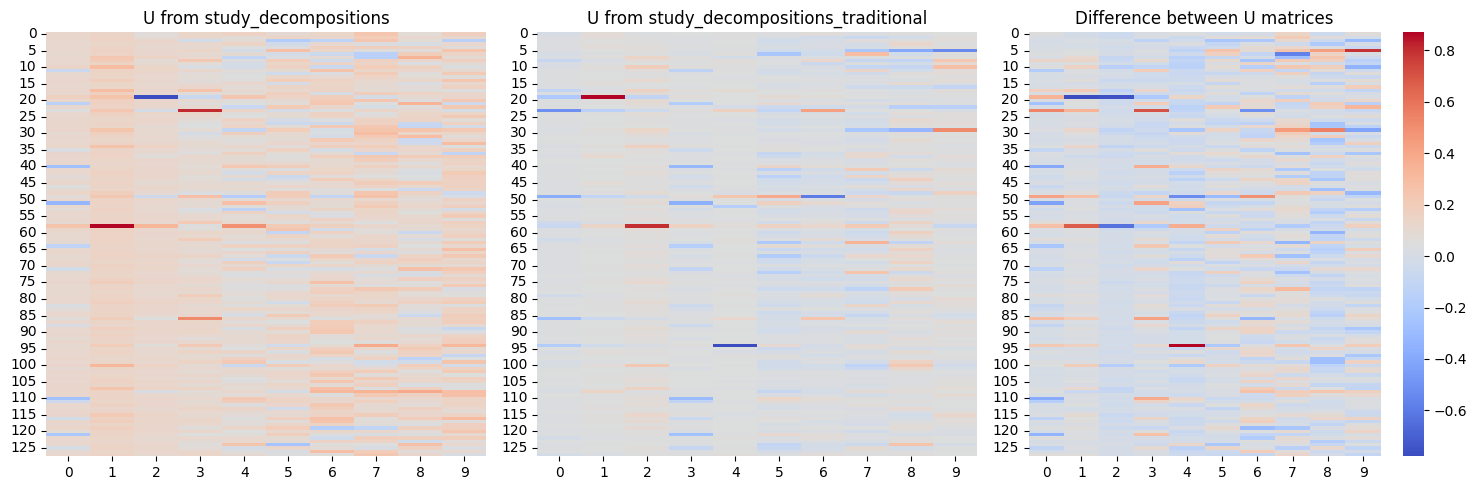

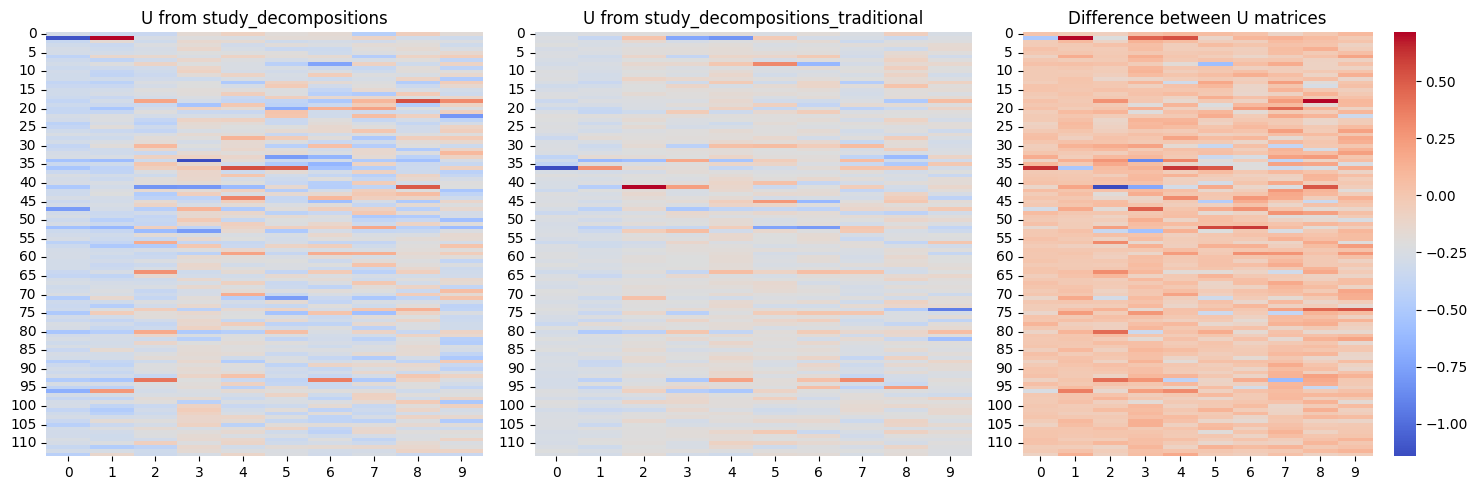

In [19]:
for study in unique_studies:
    plot_study_U(study)